<center>
<h1>Network Intrusion Detection System</h1>
</center>

- Task is to build a network intrusion detetection system to detect anamolies and attacks in the network.
- There are two problems
  1. Binomial Classification - Wheteher the activity isnormal or its an attack
  2. Multinomial classification- Activity is normal or DoS or Probe, R2L, U2R


In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.feature_selection import f_regression

import statsmodels.formula.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 432x216 with 0 Axes>

#### Loading the data

In [4]:
data=pd.read_csv('E:\\Datasets\\NSL_Dataset\\Train.txt',header=None)

In [5]:
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15


In [6]:
# Renaming columns

In [7]:
data.columns=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [8]:
data.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


#### Analysing the entire data through pandas profiling

In [11]:
pandas_profiling.ProfileReport(data)

Number of variables,43
Number of observations,125973
Total Missing (%),0.0%
Total size in memory,41.3 MiB
Average record size in memory,344.0 B
Numeric,26
Categorical,4
Boolean,5
Date,0
Text (Unique),0
Rejected,8


#### Re-defining the target variable(attack) as target-converting attack variable with 'normal' as 0's and remaining as 1's

In [12]:
data['attack'].head()

0     normal
1     normal
2    neptune
3     normal
4     normal
Name: attack, dtype: object

In [13]:
data['target']=np.where((data['attack']=='normal'),0,1)

In [14]:
data['target'].head()

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int32

- Numerial and categorial data separation

In [15]:
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

In [16]:
numeric_vars=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64','float32','int64','int32']]
cat_vars=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]
print('-----------------------------------------------'+style.BOLD+'Numerical Features'+style.END+'--------------------------------------------------------------')
print(numeric_vars)
print('-----------------------------------------------------------------------------------------------------------------------------')
print('\n-----------------------------------------------'+style.BOLD+'Categorical Features'+style.END+'----------------------------------------------------------')
print(cat_vars)
print('-----------------------------------------------------------------------------------------------------------------------------')

-----------------------------------------------Numerical Features--------------------------------------------------------------
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'last_flag', 'target']
-----------------------------------------------------------------------------------------------------------------------------

-----------------------------

In [17]:
data_num=data[numeric_vars]
data_num.head(3)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,target
0,0,491,0,0,0,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,20,0
1,0,146,0,0,0,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,15,0
2,0,0,0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,19,1


In [18]:
#Removing attack variable from the list as its been redifned as a target variable
cat_vars.remove('attack')

In [19]:
data_cat=data[cat_vars]
data_cat.head(3)

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0


- Creating data audit report

In [20]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])



num_summary=data_num.apply(lambda x: var_summary(x)).T

In [21]:
num_summary.round(3)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
duration,125973.0,0.0,3.617247e+07,287.145,0.00,2604.515,6.783500e+06,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4.00,9590.56,4.290800e+04
src_bytes,125973.0,0.0,5.740179e+09,45566.743,44.00,5870331.182,3.446079e+13,0.0,0.0,0.00,0.00,0.00,44.00,276.00,848.00,1480.00,54540.00,1.379964e+09
dst_bytes,125973.0,0.0,2.491634e+09,19779.114,0.00,4021269.151,1.617061e+13,0.0,0.0,0.00,0.00,0.00,0.00,516.00,3375.80,8314.00,25519.00,1.309937e+09
land,125973.0,0.0,2.500000e+01,0.000,0.00,0.014,0.000000e+00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.0,2.858000e+03,0.023,0.00,0.254,6.400000e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.0,1.400000e+01,0.000,0.00,0.014,0.000000e+00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.0,2.575000e+04,0.204,0.00,2.150,4.622000e+00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,7.700000e+01
num_failed_logins,125973.0,0.0,1.540000e+02,0.001,0.00,0.045,2.000000e-03,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.0,4.985200e+04,0.396,0.00,0.489,2.390000e-01,0.0,0.0,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.000000e+00
num_compromised,125973.0,0.0,3.517800e+04,0.279,0.00,23.942,5.732210e+02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,7.479000e+03


In [22]:
#Handling Outliers 
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

data_num=data_num.apply(lambda x: outlier_capping(x))

In [23]:
#Handling missings 
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num=data_num.apply(lambda x: Missing_imputation(x))

In [24]:
data_num.corr()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,target
duration,1.000000,0.011740,0.036892,NaN,NaN,NaN,0.021274,NaN,-0.064537,0.062081,...,-0.139504,0.323505,0.276602,-0.034260,-0.078251,-0.077955,0.150304,0.171099,-0.146935,0.009284
src_bytes,0.011740,1.000000,0.127827,NaN,NaN,NaN,0.379973,NaN,0.163275,0.603363,...,0.068032,-0.036771,0.017300,-0.030134,-0.099584,-0.099962,-0.045250,-0.047174,-0.244251,-0.004409
dst_bytes,0.036892,0.127827,1.000000,NaN,NaN,NaN,0.127002,NaN,0.422000,0.237363,...,0.311322,-0.131369,-0.080879,-0.015249,-0.208829,-0.208729,-0.120730,-0.109379,0.098952,-0.289517
land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wrong_fragment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urgent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hot,0.021274,0.379973,0.127002,NaN,NaN,NaN,1.000000,NaN,0.168938,0.423630,...,0.013810,-0.028852,-0.038698,-0.034278,-0.085733,-0.085295,-0.035993,-0.037023,-0.242288,0.006637
num_failed_logins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
logged_in,-0.064537,0.163275,0.422000,NaN,NaN,NaN,0.168938,NaN,1.000000,0.125493,...,0.604058,-0.256065,-0.160994,-0.052832,-0.491478,-0.493264,-0.275972,-0.272806,0.307472,-0.690171
num_compromised,0.062081,0.603363,0.237363,NaN,NaN,NaN,0.423630,NaN,0.125493,1.000000,...,0.059500,-0.027771,-0.034179,-0.016598,-0.046812,-0.050796,-0.022847,-0.020500,-0.278755,0.049946


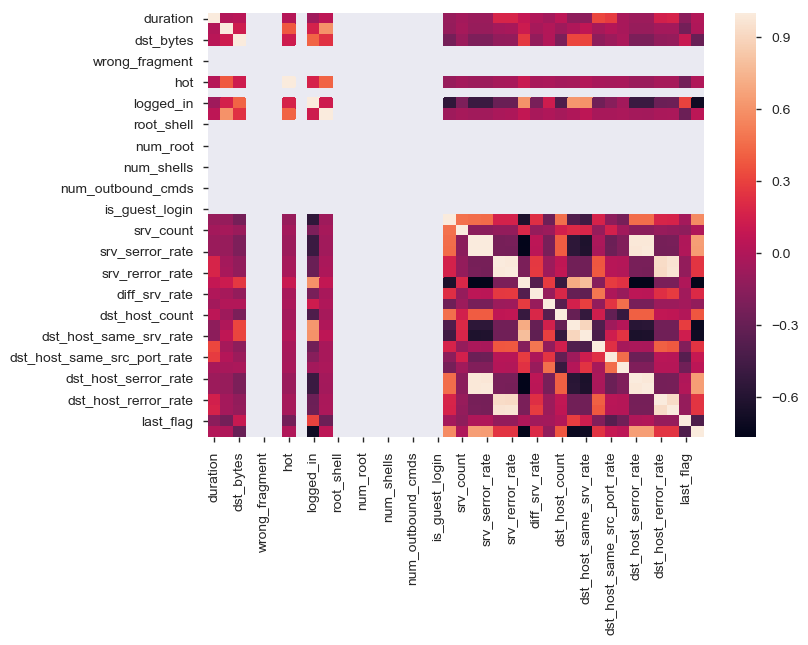

In [27]:
# visualizing correlation matrix in Seaborn using a heatmap
sns.heatmap(data_num.corr())

In [28]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=data_cat.apply(cat_summary)

In [29]:
cat_summary

,protocol_type,service,flag
N,125973,125973,125973
NMISS,0,0,0
ColumnsNames,tcp 102689 udp 14993 icmp 8291 N...,http 40338 private 21853 doma...,SF 74945 S0 34851 REJ 1123...


- Handling Categorical features - Nominal data - Dummy variable creation

In [30]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [31]:
data_cat_new = data_cat
for c_feature in cat_vars:
    data_cat_new[c_feature] = data_cat_new[c_feature].astype('category')
    data_cat_new = create_dummies(data_cat_new , c_feature )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
data_cat_new.head(3)

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
data_new = pd.concat([data_num, data_cat_new], axis=1)

In [34]:
data_new.shape

(125973, 121)

####  Feature Selection

#### Dropping columns based on data audit report
        - Based on low variance (near zero variance)
        - High missings (>25% missings)
        - High correlations between two numerical variables

- Features having zero variance - [ land, urgent, num_shells, num_outbound_cmds, is_host_login]

In [35]:
data_new=data_new.drop(columns=['land','num_shells','num_outbound_cmds','is_host_login','urgent'],axis=1)

In [36]:
data_new.shape

(125973, 116)

- High correlations between two numerical numbers- [dst_host_rerror_rate, dst_host_serror_rate, dst_host_srv_rerror_rate, dst_host_srv_serror_rate, num_root, srv_rerror_rate, srv_serror_rate]

In [37]:
data_new=data_new.drop(columns=['dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'num_root', 'srv_rerror_rate','srv_serror_rate'])

In [38]:
data_new.shape

(125973, 109)

#### Variable reduction using RFE

- Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [40]:
X = data_new[data_new.columns.difference(['target'])]
logreg = LogisticRegression()
rfe = RFE(logreg, 15)
rfe = rfe.fit(X, data_new['target'] )
print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True False False  True False False False
 False False False  True  True  True  True False False False False False
 False  True False False False False False False  True  True False False
 False False False False False False False False False False False  True
  True False False False False False  True False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False]
[74 10 82 78 54  1  2 77  1 81 44 33 13 43  6  1  1  1  1 60  7 90 64 67
 89  1 88 91 73 69  5 92  1  1 63 27 84 59 32 34 37 25 49 19 58 62 20  1
  1 41 56 66  8  4  1 85 38 11 87 30 86  1 35 51 53 47 29 16 31 24 50 52
 18 46 36  3 65 71  9 21 70 17  1 79 57 55 72 14 42 15 40 45 28 12 61 80
 68 76 22  1 26 39 23 83 75 48 93 94]


In [41]:
# summarize the selection of the attributes
import itertools
feature_map = [(i, v) for i, v in itertools.zip_longest(X.columns, rfe.get_support())]

feature_map

#Alternative of capturing the important variables
RFE_features=X.columns[rfe.get_support()]



In [42]:
RFE_features

Index(['dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'flag_S1',
       'flag_S2', 'flag_S3', 'flag_SF', 'num_compromised', 'same_srv_rate',
       'serror_rate', 'service_eco_i', 'service_ecr_i', 'service_gopher',
       'service_imap4', 'service_private', 'service_uucp'],
      dtype='object')

#### Variable reduction using Select K-Best technique

In [43]:
X = data_new[data_new.columns.difference(['target'])]
X_new = SelectKBest(f_classif, k=15).fit(X, data_new[['target']] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  31 106 107] are constant.
  UserWarning)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [44]:
X_new.get_support()

array([ True, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [45]:
X_new.scores_

array([6.26896630e+04, 5.45104214e+03, 1.15248837e+04, 2.06200937e+04,
       7.89820523e+03, 1.08582416e+03, 1.16917277e+05, 1.37598575e+05,
       3.83894406e+02, 1.08592929e+01, 4.46159944e+03, 9.96512343e+02,
       1.18513146e+02, 2.27187933e+03, 9.22617741e+04, 3.04597014e+02,
       8.28004865e+01, 2.90252349e+01, 1.68332132e+05, 3.04118462e+02,
       5.54939475e+00,            nan, 2.46148039e+04, 1.14585761e+05,
                  nan, 3.15036970e+02,            nan,            nan,
       3.56547671e+02, 6.23608544e+03, 8.64361750e+03,            nan,
       1.63866577e+05, 9.24815048e+04, 4.31288185e+01, 1.00485986e+03,
       2.29726175e+00, 3.20412385e+02, 8.25496735e+02, 8.53754616e+02,
       6.31855941e+02, 6.52926913e+02, 6.03781617e+02, 6.23665200e+02,
       5.04741759e+02, 9.05239880e+03, 5.02206303e+02, 3.57329609e+03,
       2.89936873e+03, 5.61713586e+02, 5.48869854e+02, 3.69465505e+02,
       8.98024320e-01, 1.08358802e+03, 6.00273957e+02, 2.29726175e+00,
      

In [46]:
# summarize the selection of the attributes
import itertools
feature_map = [(i, v) for i, v in itertools.zip_longest(X.columns, X_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features=X.columns[X_new.get_support()]



In [47]:
KBest_features

Index(['count', 'dst_bytes', 'dst_host_count', 'dst_host_same_srv_rate',
       'dst_host_srv_count', 'flag_S0', 'flag_SF', 'last_flag', 'logged_in',
       'rerror_rate', 'same_srv_rate', 'serror_rate', 'service_domain_u',
       'service_http', 'service_private'],
      dtype='object')

#### F Regression

In [48]:
F_values, p_values  = f_regression(  X, data_new['target'] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [49]:
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(X.columns, F_values,  ['%.3f' % p for p in p_values])]

In [50]:
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

In [51]:
f_reg_results.sort_values(by=['F_Value'], ascending=False)

,Variable,F_Value,P_Value
18,flag_SF,168332.131566,0.000
32,same_srv_rate,163866.577206,0.000
7,dst_host_srv_count,137598.574951,0.000
6,dst_host_same_srv_rate,116917.276744,0.000
23,logged_in,114585.761111,0.000
33,serror_rate,92481.504759,0.000
14,flag_S0,92261.774118,0.000
0,count,62689.662976,0.000
57,service_http,58249.601370,0.000
82,service_private,31936.471111,0.000


- selecting top 30 variables from F regression

In [52]:
a=f_reg_results.sort_values(by=['F_Value'], ascending=False).reset_index(drop=True)

In [53]:
a=a.loc[(a.index<=30),['Variable']]

In [54]:
F_Variables=list(a['Variable'])

In [55]:
F_Variables

['flag_SF',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'logged_in',
 'serror_rate',
 'flag_S0',
 'count',
 'service_http',
 'service_private',
 'last_flag',
 'dst_host_count',
 'dst_bytes',
 'service_domain_u',
 'rerror_rate',
 'dst_host_diff_srv_rate',
 'protocol_type_udp',
 'service_smtp',
 'diff_srv_rate',
 'flag_REJ',
 'service_eco_i',
 'service_ecr_i',
 'flag_RSTR',
 'srv_diff_host_rate',
 'dst_host_same_src_port_rate',
 'service_ftp_data',
 'service_Z39_50',
 'flag_RSTO',
 'service_uucp',
 'service_courier',
 'service_bgp']

- Seleting varibles which are common from allthe threee techniques

In [56]:
variables=F_Variables+list(KBest_features)+list(RFE_features)

In [57]:
selected_vars=set(variables)

In [58]:
selected_vars

{'count',
 'diff_srv_rate',
 'dst_bytes',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_same_srv_rate',
 'dst_host_srv_count',
 'dst_host_srv_diff_host_rate',
 'flag_REJ',
 'flag_RSTO',
 'flag_RSTR',
 'flag_S0',
 'flag_S1',
 'flag_S2',
 'flag_S3',
 'flag_SF',
 'last_flag',
 'logged_in',
 'num_compromised',
 'protocol_type_udp',
 'rerror_rate',
 'same_srv_rate',
 'serror_rate',
 'service_Z39_50',
 'service_bgp',
 'service_courier',
 'service_domain_u',
 'service_eco_i',
 'service_ecr_i',
 'service_ftp_data',
 'service_gopher',
 'service_http',
 'service_imap4',
 'service_private',
 'service_smtp',
 'service_uucp',
 'srv_diff_host_rate'}

In [59]:
all_columns = "+".join(selected_vars)
my_formula = "target~" + all_columns

print(my_formula)

target~service_imap4+service_domain_u+dst_host_same_src_port_rate+flag_S2+dst_host_srv_count+service_private+dst_host_same_srv_rate+service_bgp+last_flag+dst_bytes+serror_rate+same_srv_rate+flag_SF+flag_S0+diff_srv_rate+flag_RSTR+protocol_type_udp+service_courier+flag_S3+service_Z39_50+srv_diff_host_rate+service_ecr_i+rerror_rate+num_compromised+service_smtp+service_uucp+flag_REJ+dst_host_diff_srv_rate+service_eco_i+dst_host_srv_diff_host_rate+flag_S1+service_http+count+service_ftp_data+dst_host_count+service_gopher+logged_in+flag_RSTO


In [60]:
my_formula='target~service_private+count+service_domain_u+service_uucp+flag_REJ+service_ecr_i+dst_host_srv_diff_host_rate+flag_S2+flag_RSTR+dst_host_same_src_port_rate+srv_diff_host_rate+service_bgp+service_courier+service_smtp+service_imap4+service_gopher+dst_bytes+diff_srv_rate+service_ftp_data+flag_RSTO+service_Z39_50+flag_S1+last_flag+dst_host_diff_srv_rate+dst_host_count+num_compromised+flag_S3'

In [61]:
y, X = dmatrices(my_formula, data_new, return_type='dataframe')

In [62]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,165.240932,Intercept
10,2.053362,dst_host_same_src_port_rate
7,2.045720,dst_host_srv_diff_host_rate
25,1.870729,dst_host_count
24,1.809501,dst_host_diff_srv_rate
2,1.794769,count
11,1.552478,srv_diff_host_rate
23,1.542732,last_flag
18,1.495123,diff_srv_rate
6,1.457866,service_ecr_i


In [63]:
my_formula

'target~service_private+count+service_domain_u+service_uucp+flag_REJ+service_ecr_i+dst_host_srv_diff_host_rate+flag_S2+flag_RSTR+dst_host_same_src_port_rate+srv_diff_host_rate+service_bgp+service_courier+service_smtp+service_imap4+service_gopher+dst_bytes+diff_srv_rate+service_ftp_data+flag_RSTO+service_Z39_50+flag_S1+last_flag+dst_host_diff_srv_rate+dst_host_count+num_compromised+flag_S3'

In [64]:
my_formula='target~service_private+count+service_domain_u+service_ecr_i+dst_host_srv_diff_host_rate+flag_S2+flag_RSTR+dst_host_same_src_port_rate+srv_diff_host_rate+service_smtp+service_imap4+dst_bytes+diff_srv_rate+service_ftp_data+flag_RSTO+flag_S1+last_flag+dst_host_diff_srv_rate+dst_host_count+num_compromised+flag_S3'

In [65]:
logreg = sm.logit(my_formula,data=data_new)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.125608
         Iterations 12


In [66]:
print(result.summary2())

                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.818     
Dependent Variable:       target               AIC:                  31690.4975
Date:                     2019-07-08 10:13     BIC:                  31904.8616
No. Observations:         125973               Log-Likelihood:       -15823.   
Df Model:                 21                   LL-Null:              -87016.   
Df Residuals:             125951               LLR p-value:          0.0000    
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           12.0000                                              
-------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------
Intercept                    11.2046   0.1686  66.4614 0.0000  10.8742  1

- Final list of selected features: 
- ['service_private','count','service_domain_u','service_ecr_i','dst_host_srv_diff_host_rate','flag_S2','flag_RSTR','dst_host_same_src_port_rate','srv_diff_host_rate','service_smtp','service_imap4','dst_bytes','diff_srv_rate','service_ftp_data','flag_RSTO','flag_S1','last_flag','dst_host_diff_srv_rate','dst_host_count','num_compromised','flag_S3']
   

#### Accuracy Metrics

In [67]:
train_gini = 2*metrics.roc_auc_score(data_new['target'], result.predict(data_new)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)
train_auc = metrics.roc_auc_score(data_new['target'], result.predict(data_new))
print("The AUC for the model built on the Train Data is : ", train_auc)


The Gini Index for the model built on the Train Data is :  0.9795886954038724
The AUC for the model built on the Train Data is :  0.9897943477019362


#### Testing the model built, for  new data

In [330]:
T_data=pd.read_csv('E:\\Datasets\\NSL_Dataset\\Test.txt',header=None)

In [331]:
T_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21


In [332]:
T_data.columns=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [333]:
T_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
duration                       22544 non-null int64
protocol_type                  22544 non-null object
service                        22544 non-null object
flag                           22544 non-null object
src_bytes                      22544 non-null int64
dst_bytes                      22544 non-null int64
land                           22544 non-null int64
wrong_fragment                 22544 non-null int64
urgent                         22544 non-null int64
hot                            22544 non-null int64
num_failed_logins              22544 non-null int64
logged_in                      22544 non-null int64
num_compromised                22544 non-null int64
root_shell                     22544 non-null int64
su_attempted                   22544 non-null int64
num_root                       22544 non-null int64
num_file_creations             22544 non-null int64
num_

In [334]:
pandas_profiling.ProfileReport(T_data)

Number of variables,43
Number of observations,22544
Total Missing (%),0.0%
Total size in memory,7.4 MiB
Average record size in memory,344.0 B
Numeric,26
Categorical,4
Boolean,5
Date,0
Text (Unique),0
Rejected,8


In [335]:
T_data['attack'].head()

0    neptune
1    neptune
2     normal
3      saint
4      mscan
Name: attack, dtype: object

In [336]:
T_data['target']=np.where((T_data['attack']=='normal'),0,1)

In [337]:
T_data['target'].head()

0    1
1    1
2    0
3    1
4    1
Name: target, dtype: int32

In [338]:
T_data['target'].value_counts()

1    12833
0     9711
Name: target, dtype: int64

In [339]:
numeric_vars_T=[key for key in dict(T_data.dtypes) if dict(T_data.dtypes)[key] in ['float64','float32','int64','int32']]
cat_vars_T=[key for key in dict(T_data.dtypes) if dict(T_data.dtypes)[key] in ['object']]
print('-----------------------------------------------'+style.BOLD+'Numerical Features'+style.END+'--------------------------------------------------------------')
print(numeric_vars_T)
print('-----------------------------------------------------------------------------------------------------------------------------')
print('\n-----------------------------------------------'+style.BOLD+'Categorical Features'+style.END+'----------------------------------------------------------')
print(cat_vars_T)
print('-----------------------------------------------------------------------------------------------------------------------------')

-----------------------------------------------Numerical Features--------------------------------------------------------------
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'last_flag', 'target']
-----------------------------------------------------------------------------------------------------------------------------

-----------------------------

In [340]:
T_data_num=T_data[numeric_vars_T]
T_data_num.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,target
0,0,0,0,0,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21,1
1,0,0,0,0,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21,1
2,2,12983,0,0,0,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,21,0
3,0,20,0,0,0,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,15,1
4,1,0,15,0,0,0,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11,1


In [341]:
cat_vars_T.remove('attack')

In [342]:

T_cat=T_data[cat_vars_T]
T_cat.head()

,protocol_type,service,flag
0,tcp,private,REJ
1,tcp,private,REJ
2,tcp,ftp_data,SF
3,icmp,eco_i,SF
4,tcp,telnet,RSTO


In [343]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])



num_summary_T=T_data_num.apply(lambda x: var_summary(x)).T

In [344]:
num_summary_T.round(3)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
duration,22544.0,0.0,4.933959e+06,218.859,0.00,1407.177,1.980146e+06,0.0,0.0,0.00,0.00,0.00,0.00,0.000,4.00,283.00,7589.570,57715.0
src_bytes,22544.0,0.0,2.343550e+08,10395.450,54.00,472786.431,2.235270e+11,0.0,0.0,0.00,0.00,0.00,54.00,287.000,1032.00,15876.00,283618.000,62825648.0
dst_bytes,22544.0,0.0,4.635089e+07,2056.019,46.00,21219.298,4.502586e+08,0.0,0.0,0.00,0.00,0.00,46.00,601.000,4099.10,8314.00,26032.040,1345927.0
land,22544.0,0.0,7.000000e+00,0.000,0.00,0.018,0.000000e+00,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000,1.0
wrong_fragment,22544.0,0.0,1.900000e+02,0.008,0.00,0.143,2.000000e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000,3.0
urgent,22544.0,0.0,1.600000e+01,0.001,0.00,0.036,1.000000e-03,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000,3.0
hot,22544.0,0.0,2.376000e+03,0.105,0.00,0.928,8.620000e-01,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,2.000,101.0
num_failed_logins,22544.0,0.0,4.880000e+02,0.022,0.00,0.150,2.300000e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,1.000,4.0
logged_in,22544.0,0.0,9.969000e+03,0.442,0.00,0.497,2.470000e-01,0.0,0.0,0.00,0.00,0.00,0.00,1.000,1.00,1.00,1.000,1.0
num_compromised,22544.0,0.0,2.703000e+03,0.120,0.00,7.270,5.284700e+01,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.00,1.000,796.0


In [345]:
#Handling Outliers 
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

T_data_num_T=T_data_num.apply(lambda x: outlier_capping(x))

In [346]:
#Handling missings 
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

T_data_num=T_data_num.apply(lambda x: Missing_imputation(x))

In [347]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

T_cat_summary=T_cat.apply(cat_summary)

In [348]:
T_cat_summary

,protocol_type,service,flag
N,22544,22544,22544
NMISS,0,0,0
ColumnsNames,tcp 18880 udp 2621 icmp 1043 Name...,http 7853 private 4774 telnet...,SF 14875 REJ 3850 S0 201...


In [349]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [350]:
T_data_cat_new = T_cat
for c_feature in cat_vars_T:
    T_data_cat_new[c_feature] = T_data_cat_new[c_feature].astype('category')
    T_data_cat_new = create_dummies(T_data_cat_new , c_feature )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [351]:
T_data_cat_new

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [352]:
T_data_new = pd.concat([T_data_num, T_data_cat_new], axis=1)

In [353]:
T_data_new.shape

(22544, 115)

 - Feature selection
 -  Features having zero variance - [ land, urgent, num_shells, num_outbound_cmds, is_host_login]

In [354]:
T_data_new=T_data_new.drop(columns=['land','num_shells','num_outbound_cmds','is_host_login','urgent'],axis=1)

- High correlations between two numerical numbers- [dst_host_rerror_rate, dst_host_serror_rate, dst_host_srv_rerror_rate, dst_host_srv_serror_rate, num_root, srv_rerror_rate, srv_serror_rate]

In [355]:
T_data_new=T_data_new.drop(columns=['dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'num_root', 'srv_rerror_rate','srv_serror_rate'])

In [356]:
T_data_new.shape

(22544, 103)

In [357]:
formula='target~service_private+count+service_domain_u+service_uucp+flag_REJ+service_ecr_i+dst_host_srv_diff_host_rate+flag_S2+flag_RSTR+dst_host_same_src_port_rate+srv_diff_host_rate+service_bgp+service_courier+service_smtp+service_imap4+service_gopher+dst_bytes+diff_srv_rate+service_ftp_data+flag_RSTO+service_Z39_50+flag_S1+last_flag+dst_host_diff_srv_rate+dst_host_count+num_compromised+flag_S3'

In [96]:
a,B=dmatrices(formula, T_data_new, return_type='dataframe')

#### Accuracy metrics

In [97]:
test_gini = 2*metrics.roc_auc_score(T_data_new['target'], result.predict(T_data_new)) - 1
print("The Gini Index for the model built on the test Data is : ", test_gini)
test_auc = metrics.roc_auc_score(T_data_new['target'], result.predict(T_data_new))
print("The AUC for the model built on the test Data is : ", test_auc)

The Gini Index for the model built on the test Data is :  0.8271554188950885
The AUC for the model built on the test Data is :  0.9135777094475442


In [98]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(data_new))
train_predicted_prob.columns = ['prob']
train_actual = data_new['target']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
0,0.0,0.025181
1,0.0,0.925672
2,1.0,0.996220
3,0.0,0.000121
4,0.0,0.109234


In [99]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(T_data_new))
test_predicted_prob.columns = ['prob']
test_actual = T_data_new['target']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
0,1,0.999573
1,1,0.988907
2,0,0.007292
3,1,0.921621
4,1,0.987132


In [100]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

In [101]:
roc_like_df

,cutoff,sensitivity,specificity,accuracy
0,0.000000,1.000000,0.000000,0.465417
0,0.020408,0.999045,0.641299,0.807800
0,0.040816,0.998209,0.758223,0.869917
0,0.061224,0.997800,0.830985,0.908623
0,0.081633,0.997459,0.873290,0.931080
0,0.102041,0.997135,0.897020,0.943615
0,0.122449,0.996384,0.909285,0.949823
0,0.142857,0.995787,0.916858,0.953593
0,0.163265,0.993792,0.922472,0.955665
0,0.183673,0.992495,0.927580,0.957793


In [102]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [103]:
roc_like_df.head()

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.465417,1.000000
0,0.020408,0.999045,0.641299,0.807800,1.640344
0,0.040816,0.998209,0.758223,0.869917,1.756432
0,0.061224,0.997800,0.830985,0.908623,1.828784
0,0.081633,0.997459,0.873290,0.931080,1.870749


In [104]:
#Cut-off based on highest sum(sensitivity+specicity)   - common way of identifying cut-off
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.44898,0.974689,0.962684,0.968271,1.937372


In [105]:
#Cut-off based on highest accuracy   - some teams use this as methodology to decide the cut-off
roc_like_df[roc_like_df['accuracy']==roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.44898,0.974689,0.962684,0.968271,1.937372


In [106]:
#Choosen Best Cut-off is 0.45 based on highest (sensitivity+specicity)

test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.4498 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.4498 else 0)

In [107]:
train_predict.head()

,actual,prob,predicted
0,0.0,0.025181,0
1,0.0,0.925672,1
2,1.0,0.996220,1
3,0.0,0.000121,0
4,0.0,0.109234,0


In [108]:
test_predict.head()

,actual,prob,predicted
0,1,0.999573,1
1,1,0.988907,1
2,0,0.007292,0
3,1,0.921621,1
4,1,0.987132,1


In [109]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.968263040492804
The overall accuracy score for the Test Data  is :  0.906360894251242


In [110]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

             precision    recall  f1-score   support

        0.0       0.98      0.96      0.97     67343
        1.0       0.96      0.97      0.97     58630

avg / total       0.97      0.97      0.97    125973



In [111]:
print(metrics.classification_report(test_predict.actual, test_predict.predicted))

             precision    recall  f1-score   support

          0       0.89      0.90      0.89      9711
          1       0.92      0.91      0.92     12833

avg / total       0.91      0.91      0.91     22544



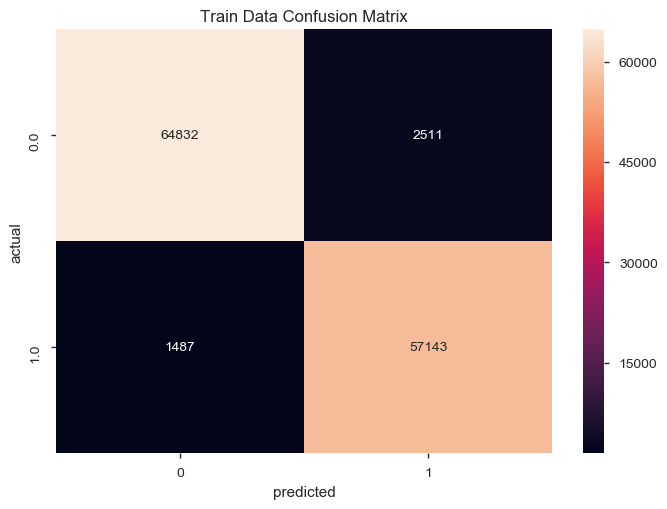

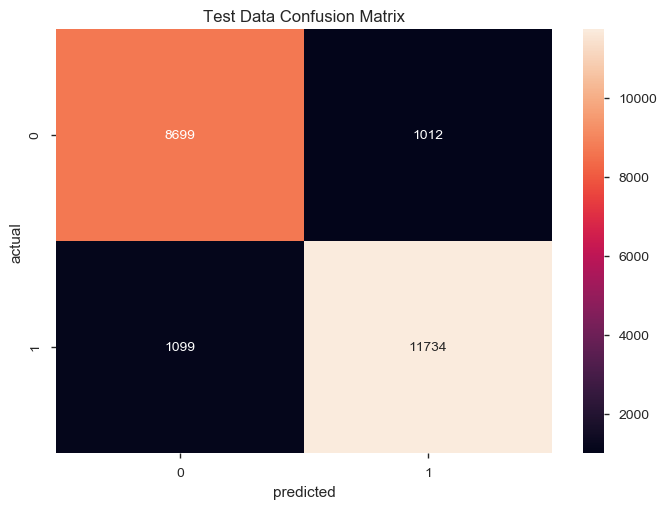

In [112]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()

### Decision Trees

In [113]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV

In [114]:
clf_tree = DecisionTreeClassifier( max_depth = 3 )
clf_tree=clf_tree.fit( X, y )

In [115]:
#train score
clf_tree.score(X,y)

0.967659736610226

In [116]:
#test Score
clf_tree.score(B,a)

0.8220812633073101

#### Fine tuning the parameters

In [117]:
param_grid = {'max_depth': np.arange(3, 15),
             'max_features': np.arange(5,20)}

In [118]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( X, y )

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [119]:
tree.best_params_

{'max_depth': 14, 'max_features': 17}

In [120]:
tree.best_score_

0.9968405928254467

In [121]:
#Buildingdecision tree model with Max_depth:14, max_features:18
dt=DecisionTreeClassifier(max_depth=14,max_features=18)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=18, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [122]:
dt.feature_importances_

array([0.00000000e+00, 2.20607683e-02, 4.41685400e-01, 8.67970760e-05,
       0.00000000e+00, 7.07608402e-04, 9.99820522e-04, 4.24823828e-03,
       1.11838396e-04, 2.18664914e-03, 1.04038037e-01, 1.47975907e-03,
       0.00000000e+00, 0.00000000e+00, 1.11402895e-03, 1.72357199e-04,
       0.00000000e+00, 2.08210168e-01, 1.36657592e-02, 1.38870903e-03,
       6.47394657e-04, 0.00000000e+00, 1.00808481e-03, 1.59544384e-01,
       2.88654460e-02, 7.21339768e-03, 5.25334527e-04, 4.00194554e-05])

In [123]:
# summarize the selection of the attributes
import itertools
feature_map = [(i, v) for i, v in itertools.zip_longest(X.columns, dt.feature_importances_)]

feature_map

[('Intercept', 0.0),
 ('service_private', 0.02206076834323216),
 ('count', 0.4416854002302134),
 ('service_domain_u', 8.679707601676419e-05),
 ('service_uucp', 0.0),
 ('flag_REJ', 0.0007076084018946931),
 ('service_ecr_i', 0.0009998205224805066),
 ('dst_host_srv_diff_host_rate', 0.004248238284050221),
 ('flag_S2', 0.00011183839632183479),
 ('flag_RSTR', 0.0021866491351009132),
 ('dst_host_same_src_port_rate', 0.10403803746024762),
 ('srv_diff_host_rate', 0.0014797590711225672),
 ('service_bgp', 0.0),
 ('service_courier', 0.0),
 ('service_smtp', 0.001114028954990021),
 ('service_imap4', 0.00017235719921551007),
 ('service_gopher', 0.0),
 ('dst_bytes', 0.20821016754684357),
 ('diff_srv_rate', 0.013665759176574577),
 ('service_ftp_data', 0.00138870903133397),
 ('flag_RSTO', 0.0006473946572485695),
 ('service_Z39_50', 0.0),
 ('flag_S1', 0.0010080848149977316),
 ('last_flag', 0.1595443840697865),
 ('dst_host_diff_srv_rate', 0.0288654459630296),
 ('dst_host_count', 0.007213397682929504),
 ('

In [124]:
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

,Feature,importance
2,count,0.441685
17,dst_bytes,0.208210
23,last_flag,0.159544
10,dst_host_same_src_port_rate,0.104038
24,dst_host_diff_srv_rate,0.028865
1,service_private,0.022061
18,diff_srv_rate,0.013666
25,dst_host_count,0.007213
7,dst_host_srv_diff_host_rate,0.004248
9,flag_RSTR,0.002187


In [125]:
tree_test_pred = pd.DataFrame( { 'actual':a.target,
                            'predicted': dt.predict(B)} )

In [126]:
tree_test_pred.head(10)

,actual,predicted
0,1.0,1.0
1,1.0,1.0
2,0.0,0.0
3,1.0,1.0
4,1.0,0.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,0.0,0.0
9,1.0,1.0


In [127]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.8255855216465579

Text(0.5,28.3611,'Predicted label')

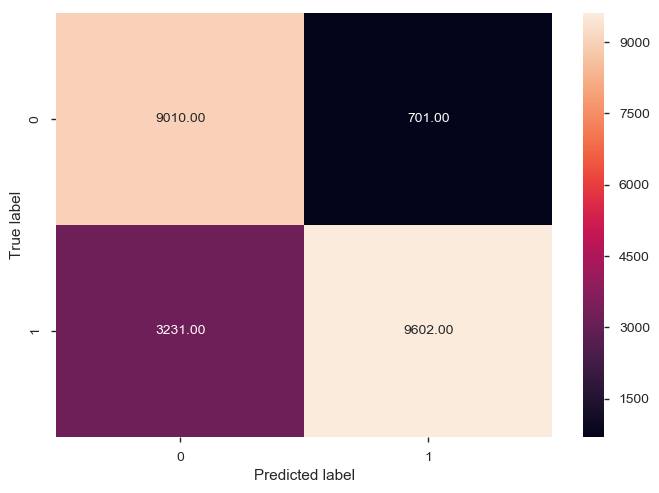

In [128]:
tree_cm = metrics.confusion_matrix( tree_test_pred.actual,tree_test_pred.predicted,
                                 
                                  )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100 , max_features=6, n_jobs=-1)
radm_clf.fit( X, y.target )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [131]:
#Test Accuracy
metrics.accuracy_score(a.target ,radm_clf.predict(B) )

0.8352111426543648

#### Tuning Parameters

In [132]:
pargrid_ada = {'n_estimators': [50, 60, 70, 80, 90, 100],
                'max_features': [12,13,14,15,16,17,18,19,20,21,22]}

from sklearn.model_selection import GridSearchCV
gscv_Rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)

In [133]:
gscv_results = gscv_Rf.fit(X, y.target)
gscv_results.best_score_

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed: 78.0min finished


0.9986663808911433

In [134]:
gscv_results.best_params_

{'max_features': 12, 'n_estimators': 80}

#### Final RF Model

In [135]:
rf_clf=RandomForestClassifier(oob_score=True,max_features=17,n_estimators=90,n_jobs=-1)

In [136]:
rf_clf.fit(X,y.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=17, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [137]:
radm_test_pred = pd.DataFrame( { 'actual':a.target,
                            'predicted': rf_clf.predict(B ) } )

metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.8268275372604684

In [138]:
radm_test_pred.head()

,actual,predicted
0,1.0,1.0
1,1.0,1.0
2,0.0,0.0
3,1.0,1.0
4,1.0,0.0


Text(0.5,28.3611,'Predicted label')

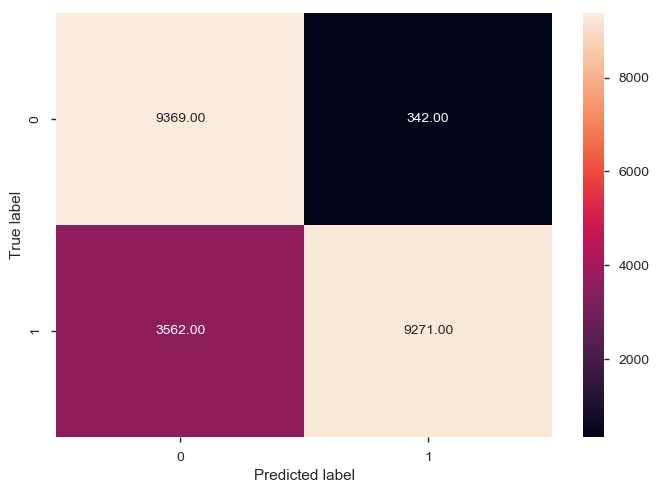

In [139]:
tree_cm = metrics.confusion_matrix(radm_test_pred.actual, radm_test_pred.predicted,
                                  )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Feature importance

In [140]:
rf_clf.feature_importances_

indices = np.argsort(rf_clf.feature_importances_)[::-1]

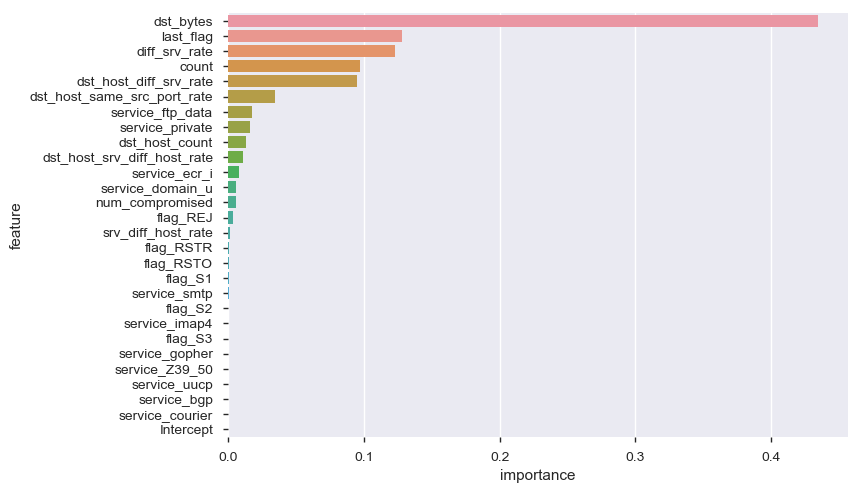

In [141]:
indices = np.argsort(rf_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         X.columns[indices[f]],
                         rf_clf.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

### Naive bayes Classifier

In [142]:
from sklearn.naive_bayes import GaussianNB

In [143]:
nb_clf = GaussianNB()
nb_clf.fit(X,y.target)

GaussianNB(priors=None)

In [144]:
nb_test_pred = pd.DataFrame( { 'actual':a.target,
                            'predicted': nb_clf.predict(B ) } )

metrics.accuracy_score( nb_test_pred.actual, nb_test_pred.predicted )

0.8479418026969482

Text(0.5,28.3611,'Predicted label')

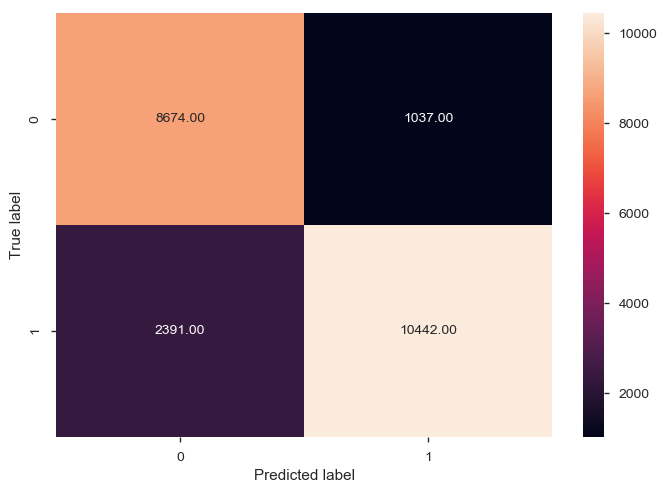

In [145]:
tree_cm = metrics.confusion_matrix( nb_test_pred.actual, nb_test_pred.predicted,
                                 )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### KNN

In [146]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
scaler = StandardScaler()

In [147]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [148]:
train_X = scaler.transform(X)
test_X = scaler.transform(B)

In [150]:
k_clf=KNeighborsClassifier(n_neighbors=17)

In [151]:
k_clf.fit(train_X,y.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [152]:
k_clf.score(train_X,y.target)

0.9950465575956753

In [153]:
metrics.accuracy_score(a.target,k_clf.predict(test_X))

0.8759315117104329

In [154]:
knn_cm = metrics.confusion_matrix(a.target, k_clf.predict( test_X ) )

Text(0.5,28.3611,'Predicted label')

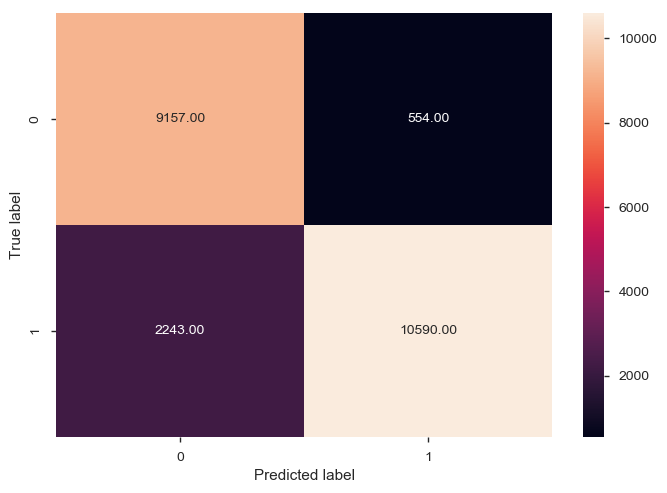

In [155]:
sns.heatmap(knn_cm, annot=True,  fmt='.2f' )
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Multinomial Classification

In [655]:
# Redefining the target variable based on attack variable

In [656]:
Dos=['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']

In [657]:
Probe=['satan','ipsweep','nmap','portsweep','mscan','saint']

In [658]:
R2l=['guess_password','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']

In [659]:
U2r=['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

#### 1--->Dos     2--->Probe     3--->R2l     4--->U2r       0---> Normal

In [660]:
multi_data=data_new

In [661]:
multi_data.head(3)

,duration,src_bytes,dst_bytes,wrong_fragment,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [662]:
# Redefining the target variable based on attack variable
#### 1--->Dos     2--->Probe     3--->R2l     4--->U2r       0---> Normal

Dos=['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']

Probe=['satan','ipsweep','nmap','portsweep','mscan','saint']

R2l=['guess_password','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']

U2r=['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']


l=[]
for i in data.attack:
    if i in Dos:
        l.append(1)
    elif i in Probe:
        l.append(2)
    elif i in R2l:
        l.append(3)
    elif i in U2r:
        l.append(4)
    else:
        l.append(0)
        

In [663]:
multi_data['target']=l

In [664]:
multi_data.target.value_counts()

0    67396
1    45927
2    11656
3      942
4       52
Name: target, dtype: int64

In [665]:
# Separting the data for each category

In [673]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=multi_data[~multi_data['target'].isin(to_drop_DoS)];
Probe_df=multi_data[~multi_data['target'].isin(to_drop_Probe)];
R2L_df=multi_data[~multi_data['target'].isin(to_drop_R2L)];
U2R_df=multi_data[~multi_data['target'].isin(to_drop_U2R)];

In [674]:
DoS_df.target.value_counts()

0    67396
1    45927
Name: target, dtype: int64

In [675]:
Probe_df.target.value_counts()

0    67396
2    11656
Name: target, dtype: int64

In [676]:
R2L_df.target.value_counts()

0    67396
3      942
Name: target, dtype: int64

In [677]:
U2R_df.target.value_counts()

0    67396
4       52
Name: target, dtype: int64

### Feature Engineering

In [678]:
# Selecting the important features for each category using select k-best

In [679]:
X_DoS=DoS_df[DoS_df.columns.difference(['target'])]
X_DoS_new=SelectKBest(f_classif, k=20).fit(X_DoS,DoS_df['target'] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 12  21  24  26  27  31  36  55  58  60  78 106 107] are constant.
  UserWarning)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [680]:
feature_map = [(i, v) for i, v in itertools.zip_longest(X_DoS.columns, X_DoS_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features_DoS=X_DoS.columns[X_DoS_new.get_support()]

In [681]:
KBest_features_DoS

Index(['count', 'dst_bytes', 'dst_host_count', 'dst_host_same_srv_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'flag_S0',
       'flag_SF', 'last_flag', 'logged_in', 'protocol_type_udp', 'rerror_rate',
       'same_srv_rate', 'serror_rate', 'service_domain_u', 'service_ecr_i',
       'service_http', 'service_private', 'service_smtp',
       'srv_diff_host_rate'],
      dtype='object')

In [586]:
#VIF

In [682]:
formula_DoS='+'.join(KBest_features_DoS)

In [683]:
formula_DoS

'count+dst_bytes+dst_host_count+dst_host_same_srv_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+flag_S0+flag_SF+last_flag+logged_in+protocol_type_udp+rerror_rate+same_srv_rate+serror_rate+service_domain_u+service_ecr_i+service_http+service_private+service_smtp+srv_diff_host_rate'

In [708]:
formula_DoS='target~count+dst_bytes+dst_host_count+dst_host_srv_count+dst_host_srv_diff_host_rate+last_flag+protocol_type_udp+rerror_rate+service_ecr_i+service_private+service_smtp+srv_diff_host_rate'

In [709]:
y_DoS,X_DoS=dmatrices(formula_DoS,data=DoS_df,return_type='dataframe')

In [710]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_DoS.values, i) for i in range(X_DoS.shape[1])]
vif["features"] = X_DoS.columns

vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,186.154715,Intercept
1,1.922825,count
4,1.817054,dst_host_srv_count
3,1.713750,dst_host_count
5,1.348459,dst_host_srv_diff_host_rate
9,1.332131,service_ecr_i
11,1.272578,service_smtp
12,1.271004,srv_diff_host_rate
10,1.259290,service_private
6,1.233168,last_flag


#### Probe

In [711]:
X_Probe=Probe_df[Probe_df.columns.difference(['target'])]
X_Probe_new=SelectKBest(f_classif, k=20).fit(X_Probe,Probe_df['target'] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  31 106 107] are constant.
  UserWarning)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [712]:
feature_map = [(i, v) for i, v in itertools.zip_longest(X_Probe.columns, X_Probe_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features_Probe=X_Probe.columns[X_Probe_new.get_support()]

In [713]:
KBest_features_Probe

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'flag_REJ',
       'flag_RSTR', 'flag_SF', 'last_flag', 'logged_in', 'protocol_type_tcp',
       'rerror_rate', 'same_srv_rate', 'service_eco_i', 'service_http',
       'service_private', 'srv_diff_host_rate'],
      dtype='object')

In [714]:
# VIF

In [715]:
formula_Probe='+'.join(KBest_features_Probe)

In [716]:
formula_Probe

'count+diff_srv_rate+dst_bytes+dst_host_diff_srv_rate+dst_host_same_src_port_rate+dst_host_same_srv_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+flag_REJ+flag_RSTR+flag_SF+last_flag+logged_in+protocol_type_tcp+rerror_rate+same_srv_rate+service_eco_i+service_http+service_private+srv_diff_host_rate'

In [729]:
formula_Probe='target~count+diff_srv_rate+dst_bytes+dst_host_same_src_port_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+flag_REJ+flag_RSTR+last_flag+protocol_type_tcp+service_private+srv_diff_host_rate'

In [730]:
y_Probe,X_Probe=dmatrices(formula_Probe,data=Probe_df,return_type='dataframe')

In [731]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_Probe.values, i) for i in range(X_Probe.shape[1])]
vif["features"] = X_Probe.columns

vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,169.379458,Intercept
4,1.870580,dst_host_same_src_port_rate
9,1.844580,last_flag
2,1.812072,diff_srv_rate
6,1.809920,dst_host_srv_diff_host_rate
5,1.782821,dst_host_srv_count
10,1.722787,protocol_type_tcp
1,1.683372,count
7,1.606379,flag_REJ
8,1.513906,flag_RSTR


In [732]:
#important features for category R2L(3)

In [733]:
X_R2L=R2L_df[R2L_df.columns.difference(['target'])]
X_R2L_new=SelectKBest(f_classif, k=20).fit(X_R2L,R2L_df['target'] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 12  21  24  26  27  31  35  36  38  39  40  41  42  43  46  49  50  54
  55  56  58  59  60  62  63  64  65  66  68  69  70  71  72  73  74  75
  78  79  81  84  85  88  90  91  92  99 100 101 102 106 107] are constant.
  UserWarning)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [734]:
feature_map = [(i, v) for i, v in itertools.zip_longest(X_R2L.columns, X_R2L_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features_R2L=X_R2L.columns[X_R2L_new.get_support()]

In [735]:
KBest_features_R2L

Index(['count', 'dst_host_count', 'dst_host_same_src_port_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'duration',
       'flag_SH', 'hot', 'last_flag', 'logged_in', 'protocol_type_tcp',
       'protocol_type_udp', 'service_domain_u', 'service_ftp',
       'service_ftp_data', 'service_http', 'service_imap4', 'src_bytes',
       'srv_count', 'srv_diff_host_rate'],
      dtype='object')

In [736]:
#VIF

In [737]:
formula_R2L='+'.join(KBest_features_R2L)

In [738]:
formula_R2L

'count+dst_host_count+dst_host_same_src_port_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+duration+flag_SH+hot+last_flag+logged_in+protocol_type_tcp+protocol_type_udp+service_domain_u+service_ftp+service_ftp_data+service_http+service_imap4+src_bytes+srv_count+srv_diff_host_rate'

In [739]:
formula_R2L='target~count+dst_host_count+dst_host_same_src_port_rate+dst_host_srv_diff_host_rate+duration+hot+last_flag+logged_in+service_ftp_data+service_http+service_imap4+src_bytes+srv_diff_host_rate'

In [740]:
y_R2L,X_R2L=dmatrices(formula_R2L,data=R2L_df,return_type='dataframe')

In [741]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_R2L.values, i) for i in range(X_R2L.shape[1])]
vif["features"] = X_R2L.columns

vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,214.132766,Intercept
10,2.037682,service_http
8,1.837407,logged_in
9,1.581766,service_ftp_data
1,1.518960,count
2,1.492619,dst_host_count
7,1.474829,last_flag
3,1.465555,dst_host_same_src_port_rate
4,1.307254,dst_host_srv_diff_host_rate
12,1.174156,src_bytes


In [742]:
# Imortant features for U2L(4)

In [743]:
X_U2R=U2R_df[U2R_df.columns.difference(['target'])]
X_U2R_new=SelectKBest(f_classif, k=20).fit(X_U2R,U2R_df['target'] )

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 12  21  24  26  27  31  35  36  38  39  40  41  42  43  46  49  50  54
  55  56  58  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  78  79  81  84  85  88  90  91  92  99 100 101 102 106 107] are constant.
  UserWarning)
C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [744]:
feature_map = [(i, v) for i, v in itertools.zip_longest(X_U2R.columns, X_U2R_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features_U2R=X_U2R.columns[X_U2R_new.get_support()]

In [745]:
KBest_features_U2R

Index(['count', 'dst_bytes', 'dst_host_count', 'dst_host_same_src_port_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'hot', 'last_flag',
       'logged_in', 'num_compromised', 'protocol_type_tcp',
       'protocol_type_udp', 'service_domain_u', 'service_ftp',
       'service_ftp_data', 'service_http', 'service_smtp', 'service_telnet',
       'srv_count', 'srv_diff_host_rate'],
      dtype='object')

In [746]:
#VIF

In [747]:
formula_U2R='+'.join(KBest_features_U2R)

In [748]:
formula_U2R

'count+dst_bytes+dst_host_count+dst_host_same_src_port_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+hot+last_flag+logged_in+num_compromised+protocol_type_tcp+protocol_type_udp+service_domain_u+service_ftp+service_ftp_data+service_http+service_smtp+service_telnet+srv_count+srv_diff_host_rate'

In [749]:
formula_U2R='target~count+dst_bytes+dst_host_count+dst_host_same_src_port_rate+dst_host_srv_count+dst_host_srv_diff_host_rate+hot+last_flag+logged_in+num_compromised+service_ftp_data+service_telnet+srv_diff_host_rate'

In [750]:
y_U2R,X_U2R=dmatrices(formula_U2R,data=U2R_df,return_type='dataframe')

In [751]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_U2R.values, i) for i in range(X_U2R.shape[1])]
vif["features"] = X_U2R.columns

vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,317.819467,Intercept
5,1.835004,dst_host_srv_count
9,1.745932,logged_in
1,1.733007,count
12,1.681625,service_telnet
8,1.639288,last_flag
3,1.442745,dst_host_count
10,1.429978,num_compromised
4,1.332490,dst_host_same_src_port_rate
11,1.322021,service_ftp_data


### Building the model

In [752]:
#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

In [753]:
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_R2L=DecisionTreeClassifier(random_state=0)
clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, y_DoS)
clf_Probe.fit(X_Probe, y_Probe)
clf_R2L.fit(X_R2L, y_R2L)
clf_U2R.fit(X_U2R, y_U2R)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Importing the test data

In [754]:
multitest_data=T_data_new

In [755]:
# Defining the target variable based on attack variable

In [756]:
t=[]
for i in T_data.attack:
    if i in Dos:
        t.append(1)
    elif i in Probe:
        t.append(2)
    elif i in R2l:
        t.append(3)
    elif i in U2r:
        t.append(4)
    else:
        t.append(0)

In [757]:
multitest_data['target']=t

In [758]:
multitest_data['target'].value_counts()

0    11235
1     7167
2     2421
3     1654
4       67
Name: target, dtype: int64

In [759]:
#splitting the data for each category

In [760]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_test_df=multitest_data[~multitest_data['target'].isin(to_drop_DoS)];
Probe_test_df=multitest_data[~multitest_data['target'].isin(to_drop_Probe)];
R2L_test_df=multitest_data[~multitest_data['target'].isin(to_drop_R2L)];
U2R_test_df=multitest_data[~multitest_data['target'].isin(to_drop_U2R)];

In [761]:
# Feature Engineering 

In [762]:
y_test_DoS,X_test_DoS=dmatrices(formula_DoS,data=DoS_test_df,return_type='dataframe')
y_test_Probe,X_test_Probe=dmatrices(formula_Probe,data=Probe_test_df,return_type='dataframe')
y_test_R2L,X_test_R2L=dmatrices(formula_R2L,data=R2L_test_df,return_type='dataframe')
y_test_U2R,X_test_U2R=dmatrices(formula_U2R,data=U2R_test_df,return_type='dataframe')

In [763]:
#Applying the model built on test data

#### Model Evaluation

In [764]:
print('DOS Accuracy Score:',clf_DoS.score(X_test_DoS, y_test_DoS))
print('Probe Accuracy Score:',clf_Probe.score(X_test_Probe, y_test_Probe))
print('R2L Accuracy score:',clf_R2L.score(X_test_R2L, y_test_R2L))
print('U2R Accuracy score:',clf_U2R.score(X_test_U2R, y_test_U2R))

DOS Accuracy Score: 0.9452233452885556
Probe Accuracy Score: 0.8897920328060925
R2L Accuracy score: 0.8875785553572814
U2R Accuracy score: 0.992125287559724


#### DoS

In [765]:
Dt_test_DoS_pred = pd.DataFrame( { 'actual':y_test_DoS.target,
                            'predicted': clf_DoS.predict(X_test_DoS) } )

metrics.accuracy_score( Dt_test_DoS_pred.actual, Dt_test_DoS_pred.predicted )

0.9452233452885556

Text(0.5,28.3611,'Predicted label')

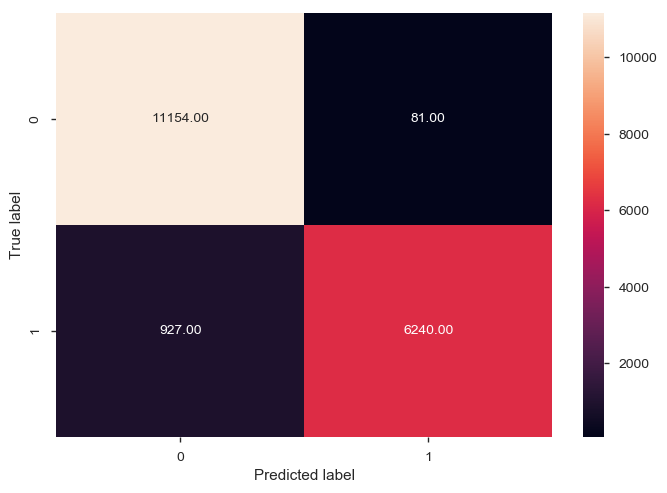

In [766]:
tree_cm_DoS = metrics.confusion_matrix(Dt_test_DoS_pred.actual,Dt_test_DoS_pred.predicted)
sns.heatmap(tree_cm_DoS, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [767]:
print(metrics.classification_report(Dt_test_DoS_pred.actual, Dt_test_DoS_pred.predicted))

             precision    recall  f1-score   support

        0.0       0.92      0.99      0.96     11235
        1.0       0.99      0.87      0.93      7167

avg / total       0.95      0.95      0.94     18402



#### Probe

In [768]:
Dt_test_Probe_pred = pd.DataFrame( { 'actual':y_test_Probe.target,
                            'predicted': clf_Probe.predict(X_test_Probe) } )

metrics.accuracy_score( Dt_test_Probe_pred.actual, Dt_test_Probe_pred.predicted )

0.8897920328060925

Text(0.5,28.3611,'Predicted label')

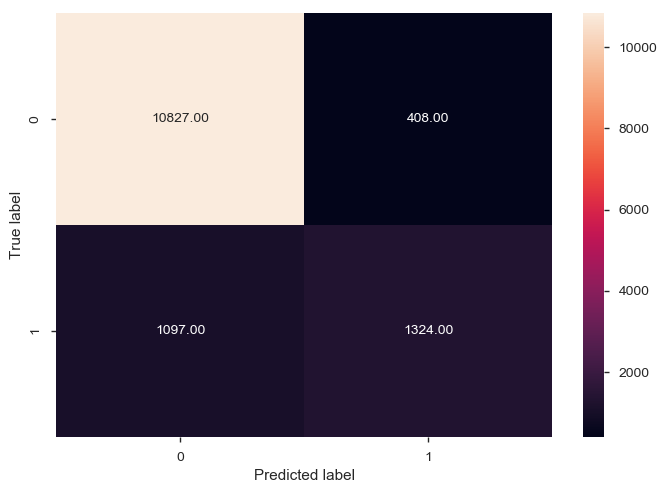

In [769]:
tree_cm_Probe = metrics.confusion_matrix(Dt_test_Probe_pred.actual,Dt_test_Probe_pred.predicted)
sns.heatmap(tree_cm_Probe, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [770]:
print(metrics.classification_report(Dt_test_Probe_pred.actual, Dt_test_Probe_pred.predicted))

             precision    recall  f1-score   support

        0.0       0.91      0.96      0.94     11235
        2.0       0.76      0.55      0.64      2421

avg / total       0.88      0.89      0.88     13656



#### R2L

In [771]:
Dt_test_R2L_pred = pd.DataFrame( { 'actual':y_test_R2L.target,
                            'predicted': clf_R2L.predict(X_test_R2L) } )

metrics.accuracy_score( Dt_test_R2L_pred.actual, Dt_test_R2L_pred.predicted )

0.8875785553572814

Text(0.5,28.3611,'Predicted label')

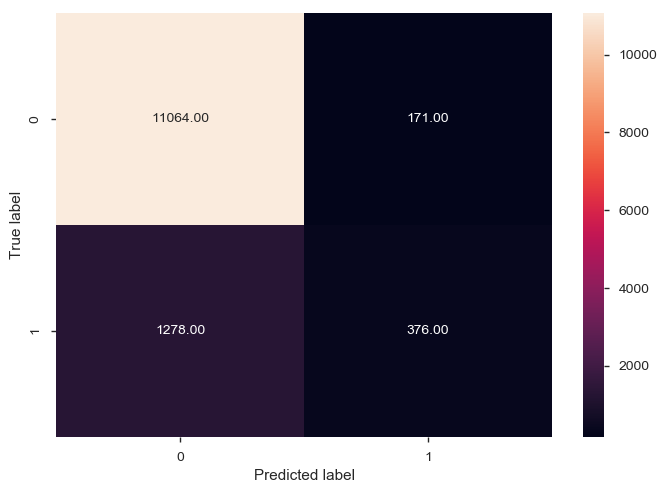

In [772]:
tree_cm_R2L = metrics.confusion_matrix(Dt_test_R2L_pred.actual,Dt_test_R2L_pred.predicted)
sns.heatmap(tree_cm_R2L, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [773]:
print(metrics.classification_report(Dt_test_R2L_pred.actual, Dt_test_R2L_pred.predicted))

             precision    recall  f1-score   support

        0.0       0.90      0.98      0.94     11235
        3.0       0.69      0.23      0.34      1654

avg / total       0.87      0.89      0.86     12889



#### U2R

In [774]:
Dt_test_U2R_pred = pd.DataFrame( { 'actual':y_test_U2R.target,
                            'predicted': clf_U2R.predict(X_test_U2R) } )

metrics.accuracy_score( Dt_test_U2R_pred.actual, Dt_test_U2R_pred.predicted )

0.992125287559724

Text(0.5,28.3611,'Predicted label')

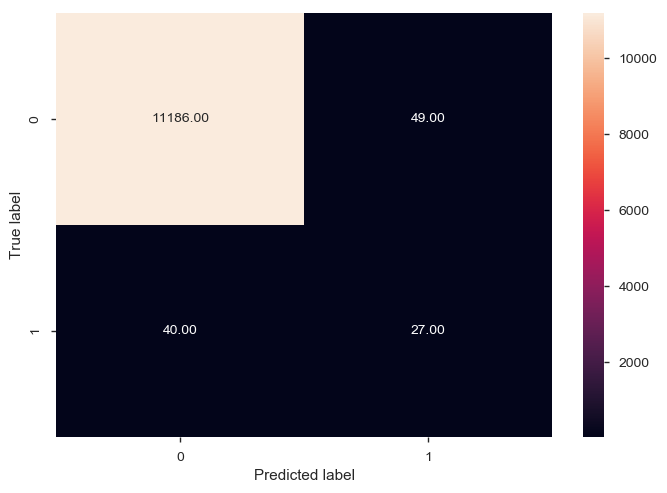

In [775]:
tree_cm_U2R = metrics.confusion_matrix(Dt_test_U2R_pred.actual,Dt_test_U2R_pred.predicted)
sns.heatmap(tree_cm_U2R, annot=True,
         fmt='.2f' )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [776]:
print(metrics.classification_report(Dt_test_U2R_pred.actual, Dt_test_U2R_pred.predicted))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     11235
        4.0       0.36      0.40      0.38        67

avg / total       0.99      0.99      0.99     11302



### Naive Bayes Classifier

In [777]:
from sklearn.naive_bayes import GaussianNB

#### DoS

In [778]:
nb_cls_DoS=GaussianNB()


In [779]:
nb_cls_DoS.fit(X_DoS,y_DoS)

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

#### Probe

In [780]:
nb_cls_Probe=GaussianNB()
nb_cls_Probe.fit(X_Probe,y_Probe)

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

#### R2L

In [781]:
nb_cls_R2L=GaussianNB()
nb_cls_R2L.fit(X_R2L,y_R2L)

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

#### U2R

In [782]:
nb_cls_U2R=GaussianNB()
nb_cls_U2R.fit(X_U2R,y_U2R)

C:\Users\vishwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

#### Applying the model built for test data

In [783]:
nb_test_DoS_pred = pd.DataFrame( { 'actual':y_test_DoS.target,
                            'predicted': nb_cls_DoS.predict(X_test_DoS) } )

metrics.accuracy_score( nb_test_DoS_pred.actual, nb_test_DoS_pred.predicted )

0.849472883382241

In [784]:
nb_test_Probe_pred = pd.DataFrame( { 'actual':y_test_Probe.target,
                            'predicted': nb_cls_Probe.predict(X_test_Probe) } )

metrics.accuracy_score( nb_test_Probe_pred.actual, nb_test_Probe_pred.predicted )

0.8551552431165788

In [785]:
nb_test_R2L_pred = pd.DataFrame( { 'actual':y_test_R2L.target,
                            'predicted': nb_cls_R2L.predict(X_test_R2L) } )

metrics.accuracy_score( nb_test_R2L_pred.actual, nb_test_R2L_pred.predicted )

0.8886647528900613

In [786]:
nb_test_U2R_pred = pd.DataFrame( { 'actual':y_test_U2R.target,
                            'predicted': nb_cls_U2R.predict(X_test_U2R) } )`

metrics.accuracy_score( nb_test_U2R_pred.actual, nb_test_U2R_pred.predicted )

0.9612457972040347